In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# # CUDA_LAUNCH_BLOCKING=1
# # os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Mount Drive

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### Download repo

In [6]:
!rm -rf YoloV3
!git clone https://github.com/theschoolofai/YoloV3.git

Cloning into 'YoloV3'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 12.74 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [7]:
# import sys
# import os
# sys.path.append(os.path.join(os.getcwd(), "YoloV3/"))

### Download Dataset

Download this [dataset](https://drive.google.com/file/d/1sVSAJgmOhZk6UG7EzmlRjXfkzPxmpmLy/view?usp=sharing) and extract it

In [8]:
!rm -rf data/customdata
!unzip -o data/customdata.zip -d data

Archive:  data/customdata.zip
   creating: data/customdata/
  inflating: data/customdata/custom.data  
 extracting: data/customdata/custom.names  
  inflating: data/customdata/custom.shapes  
   creating: data/customdata/images/
  inflating: data/customdata/images/01-prince-boots - Copy.jpg  
  inflating: data/customdata/images/026f0ffddc.jpg  
  inflating: data/customdata/images/032620_LS_covid-masks_inline-680.jpg  
  inflating: data/customdata/images/046acbc8e1.jpg  
  inflating: data/customdata/images/050bdc8229cf18030e2d8a266dd334af84-23-chelsea-boots.rsquare.w1200 - Copy.jpg  
  inflating: data/customdata/images/051fa0f9fd.jpg  
  inflating: data/customdata/images/05a207d8-6378-43a2-9d1e-431ca7a944e4-unnamed - Copy.jpg  
  inflating: data/customdata/images/088b63b347a4e40f0777df612ebe490a.jpg  
  inflating: data/customdata/images/0983a70ffe.jpg  
  inflating: data/customdata/images/0b59d3bd16.jpg  
  inflating: data/customdata/images/1-embed-activewear.jpg  
  inflating: data/cus

In [9]:
!ls data/customdata/

custom.data   custom.shapes  labels	  test.txt
custom.names  images	     test.shapes  train.txt


In [10]:
!cat data/customdata/custom.names

hardhat
vest
mask
boots

#### Download Custom dataset

1. Download WyDataset
2. Extract it
3. Merge Labels and Images to existing Dataset
4. Copy path's from `wydataset/train.txt` to  `customdata/train.txt`

### Copy and Extract Our Annotated Data

In [11]:
!rm -rf data/wydataset
!unzip -o data/wydataset.zip -d data/wydataset

Archive:  data/wydataset.zip
   creating: data/wydataset/images/
  inflating: data/wydataset/images/Boots_1.jpeg  
  inflating: data/wydataset/images/boots1.jpg  
  inflating: data/wydataset/images/boots2.jpg  
  inflating: data/wydataset/images/boots10.jpeg  
  inflating: data/wydataset/images/hardhat2.jpg  
  inflating: data/wydataset/images/hardhat3.jpg  
  inflating: data/wydataset/images/hardhat4.jpeg  
  inflating: data/wydataset/images/boots11.jpeg  
  inflating: data/wydataset/images/mask1.jpg  
  inflating: data/wydataset/images/mask2.jpg  
  inflating: data/wydataset/images/boots12.jpeg  
  inflating: data/wydataset/images/boots13.jpeg  
  inflating: data/wydataset/images/boots14.jpeg  
  inflating: data/wydataset/images/boots15.jpeg  
  inflating: data/wydataset/images/boots16.jpeg  
  inflating: data/wydataset/images/boots17.jpeg  
  inflating: data/wydataset/images/boots18.jpeg  
  inflating: data/wydataset/images/boots19.jpeg  
  inflating: data/wydataset/images/boots20.j

In [12]:
!cp -a data/wydataset/images/. data/customdata/images/
!cp -a data/wydataset/labels/. data/customdata/labels/

In [13]:
!cat data/wydataset/train.txt >> data/customdata/train.txt

#### Create a custom config file for training

1. For `COCO's 80 classes`, VOLOv3's output vector has `255 dimensions ( (4+1+80)*3)`. Now we have `4` class, so we would need to change it's architecture.
2. Copy the contents of 'yolov3-spp.cfg' file to a new file called 'yolov3-custom.cfg' file in the YoloV4/cfg folder.
Search for `filters=255` (you should get multiple entries). Change `255 to 27 = (4+1+4)*3`
3. Search for `classes=80` and change all three entries to `classes=4`
4. Since you are lazy (probably), you'll be working with very few samples. In such a case it is a good idea to change:
```
burn_in to 100
max_batches to 5000
steps to 4000,4500
```
5. Don't forget to perform the weight file steps mentioned in the section above.

In [14]:
!cp YoloV3/cfg/yolov3-spp.cfg YoloV3/cfg/yolov3-custom.cfg

Replace content as mentioned above

In [15]:
!sed -i 's/filters=255/filters=27/g' YoloV3/cfg/yolov3-custom.cfg
!sed -i 's/classes=80/classes=4/g' YoloV3/cfg/yolov3-custom.cfg

In [16]:
# burn_in=1000
# max_batches = 500200
# policy=steps
# steps=400000,450000

!sed -i 's/burn_in=1000/burn_in=100/g' YoloV3/cfg/yolov3-custom.cfg
!sed -i 's/max_batches = 500200/max_batches=5000/g' YoloV3/cfg/yolov3-custom.cfg
!sed -i 's/steps=400000,450000/steps=4000,4500/g' YoloV3/cfg/yolov3-custom.cfg

### Load Pretrained Weights

In [17]:
!mkdir YoloV3/weights

Download weights file (yolov3-spp-ultralytics.pt) from [here](https://drive.google.com/open?id=1LezFG5g3BCW6iYaV89B2i64cqEUZD7e0)

We have already downloaded and kept in drive

In [18]:
!cp data/yolov3-spp-ultralytics.pt YoloV3/weights/

### Import Libs

In [19]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
# print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [20]:
# !cd YoloV3 && python train.py --data data/smalcoco/smalcoco.data --batch 10 --cache --epochs 3 --nosave

In [21]:
!rm -rf YoloV3/data/customdata/
!cp -r data/customdata YoloV3/data/
!cd YoloV3 && python train.py --data data/customdata/custom.data --batch 10 --cache --cfg cfg/yolov3-custom.cfg --epochs 200 --nosave

!cp YoloV3/weights/last.pt data/

Namespace(accumulate=4, adam=False, batch_size=10, bucket='', cache_images=True, cfg='cfg/yolov3-custom.cfg', data='data/customdata/custom.data', device='', epochs=200, evolve=False, img_size=[512], multi_scale=False, name='', nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Quadro RTX 8000', total_memory=45556MB)

Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2984 found, 131 missing, 38 empty, 0 duplicate, for 3153 images)
Reading image shapes: 100%|█████████████████| 318/318 [00:00<00:00, 5643.95it/s]
Caching labels (297 found, 14 missing, 7 empty, 0 duplicate, for 318 images): 10
Caching images (0.1GB): 100%|████████████████| 318/318 [00:02<00:00, 144.90it/s]
Image sizes 512 - 512 train, 512 test
Using 8 dataloader workers
Starting training for 200 epochs...

     Epoch   gpu_mem      GIoU       obj       cls     total   targets

### Download a video extract and process its frames

In [22]:
!rm -rf data/frames

!mkdir data/frames
!mkdir data/frames/construction

In [23]:
!ffmpeg -i data/videos/construction_short.mp4 -vf fps=40 data/frames/construction/construction-%05d.png

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

## Run Detection

In [24]:
!rm -rf data/processed
!cd YoloV3 && python detect.py --conf-thres 0.5 --output ../data/processed/construction --source ../data/frames/construction

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-custom.cfg', classes=None, conf_thres=0.5, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/customdata/custom.names', output='../data/processed/construction', save_txt=False, source='../data/frames/construction', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Quadro RTX 8000', total_memory=45556MB)

Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Traceback (most recent call last):
  File "detect.py", line 186, in <module>
    detect()
  File "detect.py", line 26, in detect
    model.load_state_dict(torch.load(weights, map_location=device)['model'])
  File "/home/ammar/projects/.venv/lib/python3.6/site-packages/torch/serialization.py", line 592, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "/home/ammar/projects/.venv/lib/python3.6/site-packages/torch/serialization.py", line 851, 

In [25]:
!ffmpeg -r 40 -i data/processed/construction/construction-%05d.png -vcodec mpeg4 -y data/processed/out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [26]:
!rm -rf data/wydataset/special
!mkdir data/wydataset/special
!cp data/wydataset/images/Boots_11.jpeg data/wydataset/special/
!cp data/wydataset/images/Boots_12.jpeg data/wydataset/special/
!cp data/wydataset/images/Boots_14.jpeg data/wydataset/special/
!cp data/wydataset/images/Boots_3.jpeg data/wydataset/special/

!cp data/wydataset/images/hardhat1.jpeg data/wydataset/special/
!cp data/wydataset/images/hardhat11.jpeg data/wydataset/special/
!cp data/wydataset/images/hardhat15.jpeg data/wydataset/special/
!cp data/wydataset/images/hardhat17.jpeg data/wydataset/special/

!cp data/wydataset/images/mask10.jpeg data/wydataset/special/
!cp data/wydataset/images/mask19.jpeg data/wydataset/special/
!cp data/wydataset/images/mask21.jpeg data/wydataset/special/
!cp data/wydataset/images/mask24.jpeg data/wydataset/special/

!cp data/wydataset/images/Vests_1.jpeg data/wydataset/special/
!cp data/wydataset/images/Vests_12.jpeg data/wydataset/special/
!cp data/wydataset/images/Vests_13.jpeg data/wydataset/special/
!cp data/wydataset/images/Vests_18.jpeg data/wydataset/special/

In [27]:
!rm -rf data/processed/special
!cd YoloV3 && python detect.py --conf-thres 0.5 --output ../data/processed/special --source ../data/wydataset/special

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-custom.cfg', classes=None, conf_thres=0.5, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/customdata/custom.names', output='../data/processed/special', save_txt=False, source='../data/wydataset/special', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Quadro RTX 8000', total_memory=45556MB)

Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
image 1/16 ../data/wydataset/special/Boots_11.jpeg: 384x512 2 bootss, Done. (0.016s)
image 2/16 ../data/wydataset/special/Boots_12.jpeg: 384x512 2 bootss, Done. (0.013s)
image 3/16 ../data/wydataset/special/Boots_14.jpeg: 384x512 2 bootss, Done. (0.013s)
image 4/16 ../data/wydataset/special/Boots_3.jpeg: 384x512 2 bootss, Done. (0.013s)
image 5/16 ../data/wydataset/special/Vests_1.jpeg: 512x448 1 vests, Done. (0.018s)
image 6/16 ../data/wydataset/special/Vests_12.jpeg: 320x512 2 hardhats, 2 ves

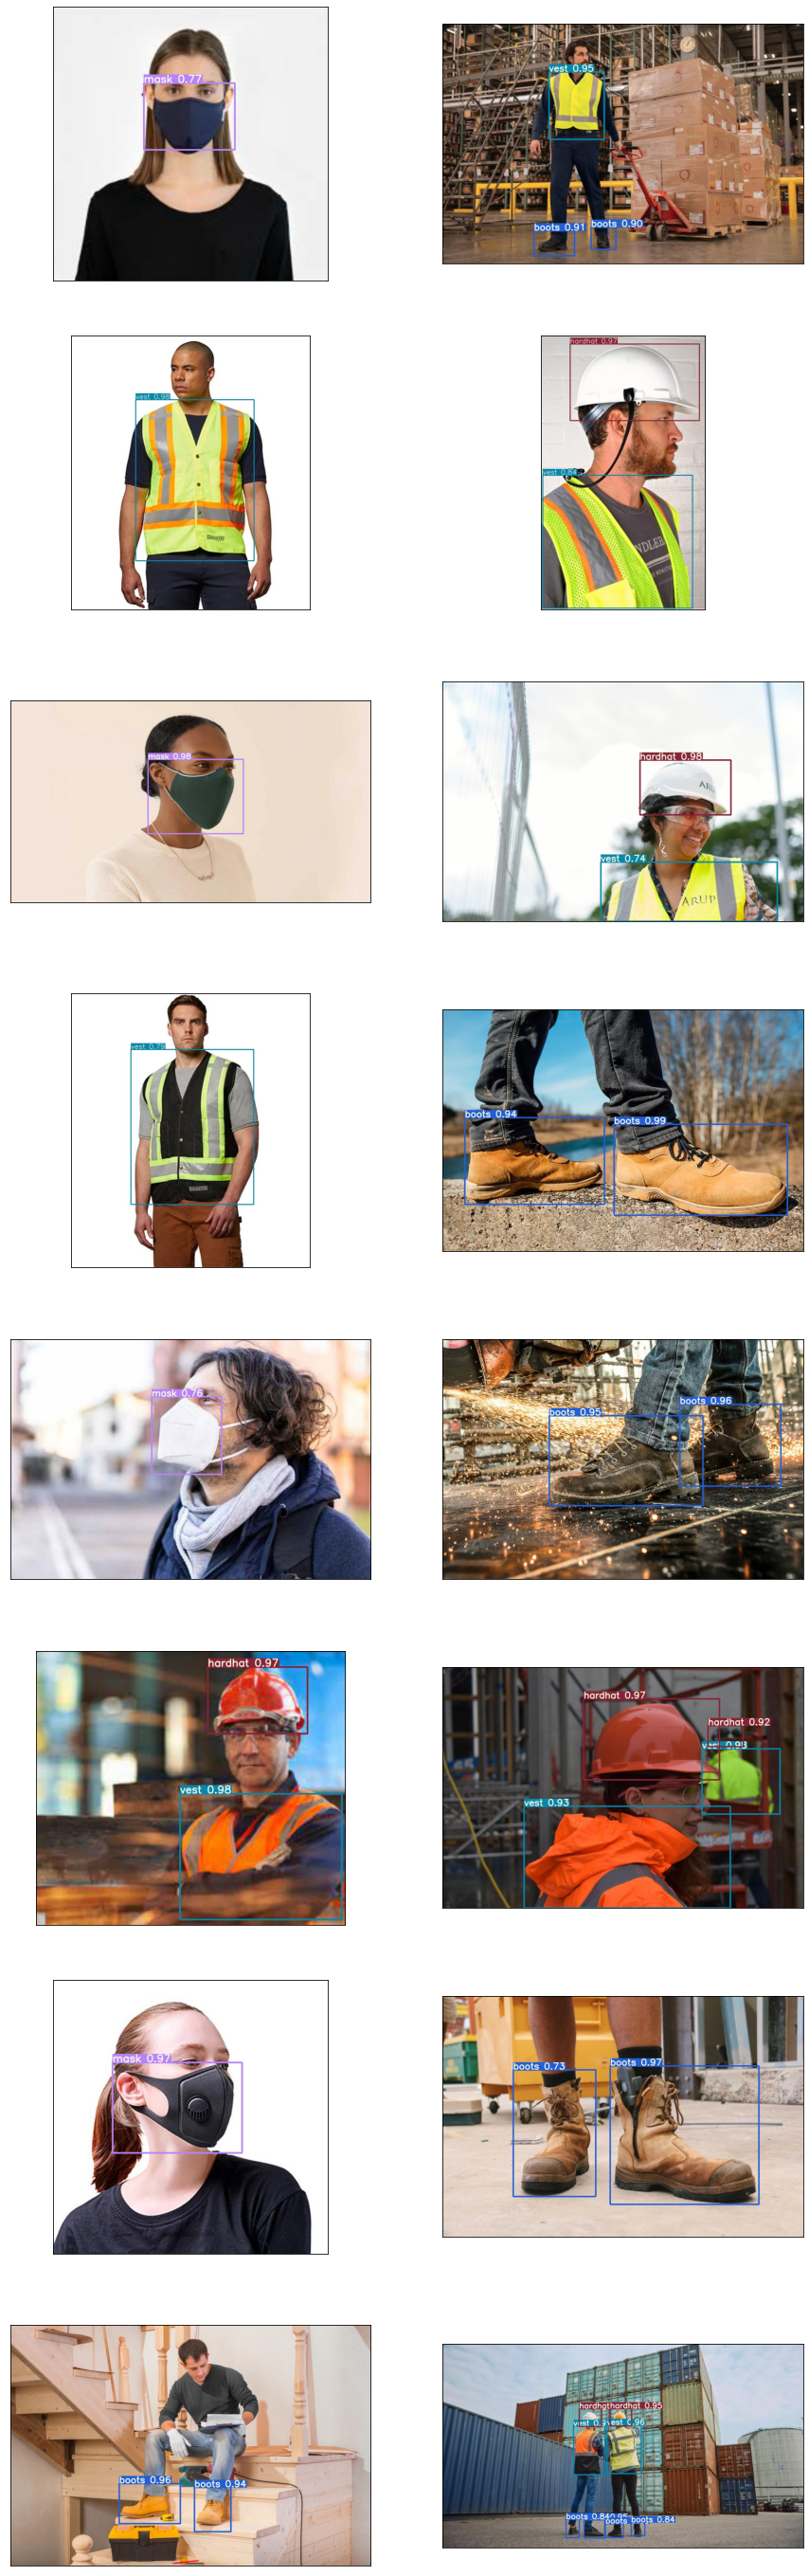

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

fig = plt.figure(figsize=(15, 50))

for i, p in enumerate(glob.glob('data/processed/special/*.jpeg')):
    ax = fig.add_subplot(8, 2, i + 1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))
plt.show()